# Scraping Tokyo's Scrappy Venues: Tokyo Gig Guide Webscraping Project




Data scraped from: http://www.tokyogigguide.com/en/gigs/eventslist?task=archive

## Introduction and Motivations

The Tokyo Gig Guide is an event listing site to which artists, venues, etc. can upload information regarding upcoming music events in the Tokyo area. Although representing primarily more "underground" venues and genres, the site does also feature listings of more "mainstream" events (festivals in particular). The above link leads to an archive of ca. 21,000 past events that occurred between 2008-2019. By collecting and analyzing this data, it is hoped that one may gain insights on trends in the unique, heterogeneous, and dynamic--albeit fragmented--Tokyo music scene. 

## Research Questions

1. What have been the most popular tags (genre categories) in recent years, compared to a decade ago? 
2. Which venues and neighborhoods of the Tokyo metro area have been the most active recently and historically? 
3. Which months are typically the densest with respect to number of events? In which year(s) have the greatest number of festivals been presented? 
4. Which neighborhoods, venues, and genres have featured the most expensive events? What have been typical price ranges for tickets? 


In [1]:
#dependencies

import pandas as pd 
import numpy as np 
import seaborn as sns 
import plotly as py 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import re 

In [2]:
%matplotlib inline 


In [3]:
from matplotlib import pyplot as plt
plt.style.use('ggplot') 

## Datasets


Data segmented into 3 tables: first 100 site pages (representing data from 2017-2019), last 100 pages (data from 2008-2010), and middle 219 pages. The data was batched in this way both to facilitate the scraping process and reduce risks of server or network disruptions, and for the sake of comparisons between recent and historical event data illustrated below. 

In [4]:
tokyo_first_100 = pd.read_csv('data/tgg_first_100_pages.csv') 
tokyo_mid = pd.read_csv('data/tgg_mid_219_pages.csv')
tokyo_last_100 = pd.read_csv('data/tgg_last_100_pages.csv')  

In [5]:
""" Convert date strings to datetime representation: """

tokyo_first_100['date'] = pd.to_datetime(tokyo_first_100['date']) 
tokyo_last_100['date'] = pd.to_datetime(tokyo_last_100['date']) 
tokyo_mid['date'] = pd.to_datetime(tokyo_mid['date'])  

#there is one event in tokyo_last_100 with a "2000" date indicated--this may have been a typo, or is an outlier. 
#In order to avoid skewing time-series analyses, it will be filtered out: 

tokyo_last_100 = tokyo_last_100[tokyo_last_100['date'] > '2001/01/01']   

In [6]:
"""Concatenate 3 datasets into 1 for subsequent time series analyses, and write to CSV. """

tokyo_all = pd.concat([tokyo_last_100, tokyo_mid, tokyo_first_100], axis = 0).sort_values('date').reset_index() 

tokyo_all.to_csv('data/tgg_all.csv')

tokyo_all.head() 


index                                              title       date  \
0   4624  Metro-Ongen, mothercoat, knock note alien, moj... 2008-07-30   
1   4625           rei harakami, Kahimi Karie, Takashi Wada 2008-08-06   
2   4631  DJs: momo 8, akashic, donbei, chipple, polymoo... 2008-09-12   
3   4630  Quartets (Kahimi, O'Rourke, Sachiko, Otomo), J... 2008-09-12   
4   4629                                       Killing Joke 2008-09-12   

       category               venue                        venue_url  \
0         Indie              Motion             http://motion-web.jp   
1  Experimental          Liquidroom        http://www.liquidroom.net   
2   Electro-Pop                 NaN                              NaN   
3  Experimental                 NaN                              NaN   
4     Post-Punk  DUO Music Exchange  http://www.duomusicexchange.com   

                             address                         access_url  \
0   5F 2-45-2 Kabukicho, Shinjuku-ku                                NaN   
1  3-16-6 Higashi, Shibuya-ku, Tokyo  http://www.liquidroom.net/access/   
2                                NaN                                NaN   
3                                NaN                                NaN   
4       2-14-8 Dogenzaka, Shibuya-ku                                NaN   

       area           closest_station advance_price door_price  
0  Shinjuku  Shinjuku, Seibu-Shinjuku           NaN        NaN  
1     Ebisu                     Ebisu           NaN        NaN  
2       NaN                       NaN           NaN        NaN  
3       NaN                       NaN           NaN        NaN  
4   Shibuya                   Shibuya           NaN        NaN

Postal Data: for subsequent mapping visualization purposes, tokyo_all will be joined with a table of geographic and postal data of the Tokyo area (postal codes and more importanty, latitude/longitude coordinates). 

In [7]:

jp_codes = pd.read_csv('data/jp_postal_codes_coords.csv')
#filter out data from geographic areas outside of Kanto (Eastern Japan): 
jp_codes = jp_codes[(jp_codes['State'] == 'Toukyouto') | (jp_codes['State'] == 'Kanagawaken') | (jp_codes['State'] == 'Saitamaken') | (jp_codes['State'] == 'Chibaken')]

tokyo_all_coords = pd.merge(tokyo_all, jp_codes, how = 'left', left_on = 'area', right_on = 'Place Name') 
#drop redundant column: 
tokyo_all_coords = tokyo_all_coords.drop('Place Name', axis = 1)

#write to csv 

tokyo_all_coords.to_csv('data/tgg_all_coords.csv')



Festival table: extract festival events from tokyo_all table. ('Festival' is a genre category.) 

In [8]:
festival_df = tokyo_all[['Festival' in x for x in tokyo_all['category']]].sort_values(by = ['title', 'date']) 


#write to csv 
festival_df.to_csv('data/tokyo_festival_table.csv')  

## EDA Pt. 1: Geographic Area and Venue Rankings/Relationships for Recent and Historic Events

Events and Venues per geographic area: 

Text(0.5,1,'Number of Events Per Area, 2017-2019')

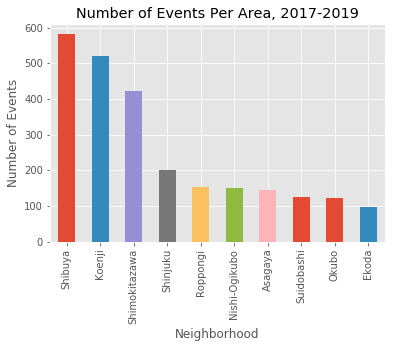

In [9]:

#recent: 
tokyo_first_100.groupby('area')['title'].agg('nunique').sort_values(ascending = False).head(10).plot.bar() 
plt.xlabel('Neighborhood') 
plt.ylabel('Number of Events')
plt.title('Number of Events Per Area, 2017-2019') 

Text(0,0.5,'Number of Events')

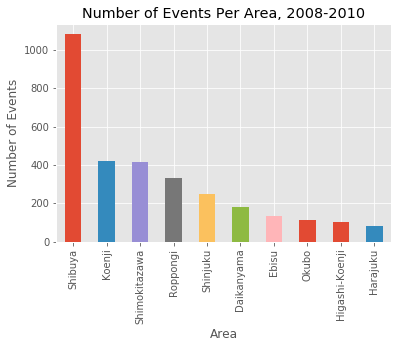

In [10]:
#historic: 

tokyo_last_100.groupby('area')['title'].agg('nunique').sort_values(ascending = False).head(10).plot.bar() 
plt.title('Number of Events Per Area, 2008-2010')
plt.xlabel('Area')
plt.ylabel('Number of Events') 

Events by venue: 

Text(0,0.5,'Venue and Area')

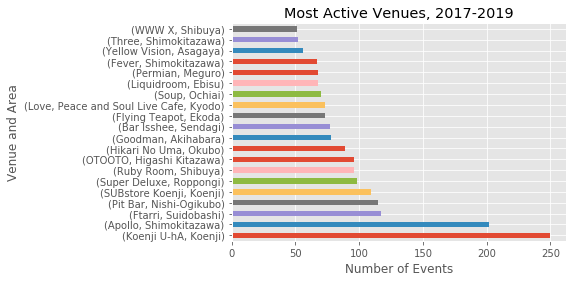

In [11]:
#recent: 

tokyo_first_top_venues = tokyo_first_100.groupby(['venue', 'area'])['title'].agg('nunique').sort_values(ascending = False).head(20).plot.barh()
plt.title('Most Active Venues, 2017-2019')
plt.xlabel('Number of Events')
plt.ylabel('Venue and Area')

Text(0.5,1,'Most Active Venues, 2008-2010')

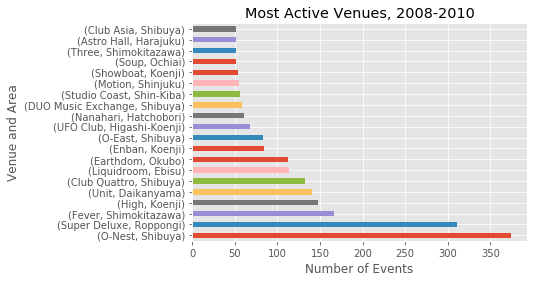

In [64]:
#historic: 

tokyo_last_100.groupby(['venue', 'area'])['title'].agg('nunique').sort_values(ascending = False).head(20).plot.barh()  
plt.xlabel('Number of Events')
plt.ylabel('Venue and Area')
plt.title('Most Active Venues, 2008-2010') 

It appears that for both recent and historic data, Shibuya has by far the most events. With the exceptions of Super Deluxe and Fever, the top-ranked venues are entirely different. Furthermore, for the 2008-2010 dataset, Shibuya is weighted to a far greater extent in the distribution than for the 2008-2010 data. It also appears that there is 1 venue with significantly number of events than the others. Could this mean that there are therefore a few venues in top-ranking areas that have presented an overwhelming number of events, or do these areas also feature a dense concentration of venues? 

Text(0.5,1,'Number of Venues per Area, 2017-2019')

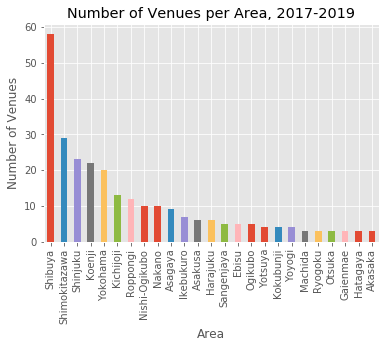

In [13]:
tokyo_area_vs_venue_first_100 = tokyo_first_100.groupby(['area'])['venue'].agg('nunique').sort_values(ascending = False).head(25).plot.bar() 
plt.xlabel('Area')
plt.ylabel('Number of Venues')
plt.title('Number of Venues per Area, 2017-2019')

Text(0.5,1,'Number of Venues per Area, 2008-2010')

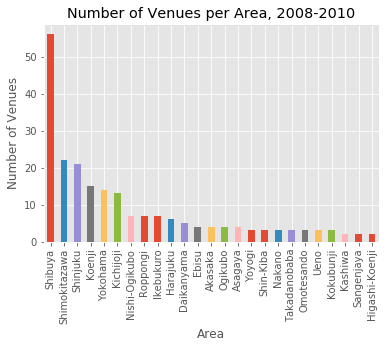

In [14]:
tokyo_area_vs_venue_last_100 = tokyo_last_100.groupby(['area'])['venue'].agg('nunique').sort_values(ascending = False).head(25).plot.bar() 
plt.xlabel('Area')
plt.ylabel('Number of Venues')
plt.title('Number of Venues per Area, 2008-2010') 

## EDA Pt. 2: Genre Category 


In [15]:
""" Genres are in list-of-string format in the original dataset. 
There are instances of multiple genre categories assigned to a single event. In order to aggregate on genres, it is necessary for each genre of 
each event to occupy a single row in the table. """


def category_sep_df (df):
    df['categories'] = df.category.apply(lambda x: x.split(',')) 
    index=0
    lst = [] 
    for item in df.categories:
        lst.extend(map(lambda x: [index, x], item))
        index += 1
    category = pd.DataFrame(lst, columns=['index', 'categories'])
    
    df = pd.merge(df.drop('category', axis =1) , category, how='right', left_index = True, right_on = 'index')
    
    return df 


tokyo_first_100_category = category_sep_df(tokyo_first_100)
tokyo_last_100_category = category_sep_df(tokyo_last_100)
    
    
    

In [16]:
tokyo_first_100_category.head(10)

title       date        venue  \
0            Daisuke Okochi, amamori, Taiga Yamazaki 2019-04-10  Koenji U-hA   
1            Daisuke Okochi, amamori, Taiga Yamazaki 2019-04-10  Koenji U-hA   
2            Daisuke Okochi, amamori, Taiga Yamazaki 2019-04-10  Koenji U-hA   
3                    Loui Lerroy, Haruka, Takumi Ito 2019-03-09       OTOOTO   
4                                       Wild Nothing 2019-04-05        WWW X   
5  Miu Mau, Kate Sikora, Transkam, Come To My Par... 2019-02-23  Green Apple   
6  Miu Mau, Kate Sikora, Transkam, Come To My Par... 2019-02-23  Green Apple   
7  Miu Mau, Kate Sikora, Transkam, Come To My Par... 2019-02-23  Green Apple   
8  Miu Mau, Kate Sikora, Transkam, Come To My Par... 2019-02-23  Green Apple   
9                          Masaki Yoshihisa (guitar) 2019-02-23      Violon    

                          venue_url  \
0     http://coffeeuha.web.fc2.com/   
1     http://coffeeuha.web.fc2.com/   
2     http://coffeeuha.web.fc2.com/   
3             http://www.otooto.jp/   
4       http://www-shibuya.jp/wwwx/   
5       http://www.greenapple.gr.jp   
6       http://www.greenapple.gr.jp   
7       http://www.greenapple.gr.jp   
8       http://www.greenapple.gr.jp   
9  http://meikyoku-kissa-violon.com   

                                             address  \
0  Ems Bldg. 4-4-12 Koenji-minami, Suginami-ku, T...   
1  Ems Bldg. 4-4-12 Koenji-minami, Suginami-ku, T...   
2  Ems Bldg. 4-4-12 Koenji-minami, Suginami-ku, T...   
3                   B1, 3-13-10 Kitazawa, Setagayaku   
4         2F Rise Bldg, 13-17 Udagawacho, Shibuya-ku   
5         Koenji-Minami 4-9-6 2F, Suginami-ku, Tokyo   
6         Koenji-Minami 4-9-6 2F, Suginami-ku, Tokyo   
7         Koenji-Minami 4-9-6 2F, Suginami-ku, Tokyo   
8         Koenji-Minami 4-9-6 2F, Suginami-ku, Tokyo   
9              Suginami-ku Asagaya-Kita 2-9-5, Tokyo   

                                 access_url              area  \
0  http://coffeeuha.web.fc2.com/access.html            Koenji   
1  http://coffeeuha.web.fc2.com/access.html            Koenji   
2  http://coffeeuha.web.fc2.com/access.html            Koenji   
3           https://goo.gl/maps/B3yidmfNBgx  Higashi Kitazawa   
4                                       NaN           Shibuya   
5   http://www.greenapple.gr.jp/access.html            Koenji   
6   http://www.greenapple.gr.jp/access.html            Koenji   
7   http://www.greenapple.gr.jp/access.html            Koenji   
8   http://www.greenapple.gr.jp/access.html            Koenji   
9                                       NaN           Asagaya   

                 closest_station advance_price  \
0                         Koenji           NaN   
1                         Koenji           NaN   
2                         Koenji           NaN   
3  Higashi-Kitazawa (3 min walk)           NaN   
4                        Shibuya          5500   
5                         Koenji           NaN   
6                         Koenji           NaN   
7                         Koenji           NaN   
8                         Koenji           NaN   
9           J.R. Asagaya station           NaN   

                                          door_price  \
0                                 2000 + drink (500)   
1                                 2000 + drink (500)   
2                                 2000 + drink (500)   
3                             ¥2,000 w/ 1 free drink   
4                                                NaN   
5                                    ¥1500 + 1 drink   
6                                    ¥1500 + 1 drink   
7                                    ¥1500 + 1 drink   
8                                    ¥1500 + 1 drink   
9  1,000 yen (inc. coffee or orange juice) no alc...   

                                  categories_x  index  categories_y  
0                       [Acoustic, Indie, Pop]      0      Acoustic  
1                       [Acoustic, Indie, Pop]      0         Indie  
2                       [

In [17]:
tokyo_first_100_category = tokyo_first_100_category.drop('categories_x', axis = 1) 
tokyo_last_100_category = tokyo_last_100_category.drop('categories_x', axis = 1)  

Text(0.5,1,'Number of Events per Genre, 2017-2019')

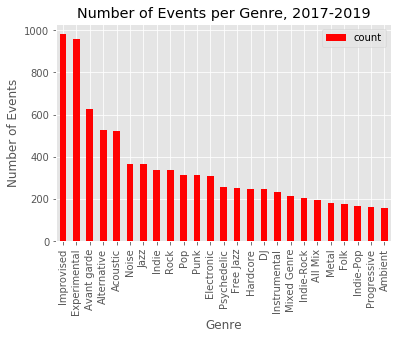

In [18]:
most_popular_cat_recent = pd.DataFrame({'count': tokyo_first_100_category.groupby('categories_y')['title'].agg('nunique').sort_values(ascending = False).head(25)})

most_popular_cat_recent.plot.bar(color = 'red')  

plt.xlabel('Genre')
plt.ylabel('Number of Events')
plt.title('Number of Events per Genre, 2017-2019') 

Text(0.5,1,'Number of Events Per Genre, 2008-2010')

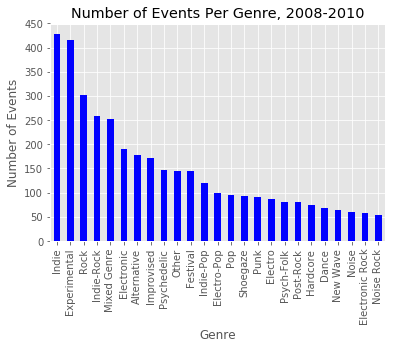

In [19]:
#historic 

most_popular_cat_old = tokyo_last_100_category.groupby('categories_y')['title'].agg('nunique').sort_values(ascending = False).head(25)
most_popular_cat_old.plot.bar(color = 'blue')  

plt.xlabel('Genre')
plt.ylabel('Number of Events')
plt.title('Number of Events Per Genre, 2008-2010')

In [20]:
tokyo_all_category = category_sep_df(tokyo_all)  
tokyo_all_category.head() 


index  index_x                                              title  \
0      0     4624  Metro-Ongen, mothercoat, knock note alien, moj...   
1      1     4625           rei harakami, Kahimi Karie, Takashi Wada   
2      2     4631  DJs: momo 8, akashic, donbei, chipple, polymoo...   
3      3     4630  Quartets (Kahimi, O'Rourke, Sachiko, Otomo), J...   
4      4     4629                                       Killing Joke   

        date               venue                        venue_url  \
0 2008-07-30              Motion             http://motion-web.jp   
1 2008-08-06          Liquidroom        http://www.liquidroom.net   
2 2008-09-12                 NaN                              NaN   
3 2008-09-12                 NaN                              NaN   
4 2008-09-12  DUO Music Exchange  http://www.duomusicexchange.com   

                             address                         access_url  \
0   5F 2-45-2 Kabukicho, Shinjuku-ku                                NaN   
1  3-16-6 Higashi, Shibuya-ku, Tokyo  http://www.liquidroom.net/access/   
2                                NaN                                NaN   
3                                NaN                                NaN   
4       2-14-8 Dogenzaka, Shibuya-ku                                NaN   

       area           closest_station advance_price door_price  \
0  Shinjuku  Shinjuku, Seibu-Shinjuku           NaN        NaN   
1     Ebisu                     Ebisu           NaN        NaN   
2       NaN                       NaN           NaN        NaN   
3       NaN                       NaN           NaN        NaN   
4   Shibuya                   Shibuya           NaN        NaN   

     categories_x  index_y  categories_y  
0         [Indie]        0         Indie  
1  [Experimental]        1  Experimental  
2   [Electro-Pop]        2   Electro-Pop  
3  [Experimental]        3  Experimental  
4     [Post-Punk]        4     Post-Punk

In comparing the 2 above bar plots, there seem to be considerable differences between recent and historic event genre rankings. "Improvised," which is top-ranking for the recent events, is ranked 8th in the historic data. In the 2017-2019 data, "Indie" is ranked 10th, after "Noise." When did this downturn in events tagged as "Indie" and increase in "Improvised"-tagged events occur? 


Text(0.5,1,'Number of Events per Year for Top-Ranking Genres of Recent and Historical Datasets')

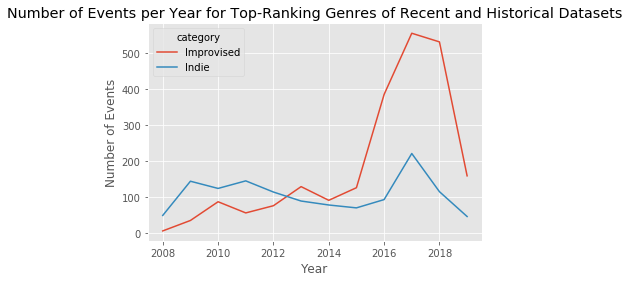

In [21]:

tokyo_all_category_top_genres = tokyo_all_category[(tokyo_all_category['categories_y'] == 'Improvised') | (tokyo_all_category['categories_y'] == 'Indie')]
tokyo_top_genres_by_year = pd.DataFrame(tokyo_all_category_top_genres.groupby([tokyo_all_category_top_genres['date'].dt.year, 'categories_y']).agg({'title': 'nunique'})).sort_index() 
tokyo_top_genres_by_year = pd.DataFrame(tokyo_top_genres_by_year.to_records()) 
tokyo_top_genres_by_year.columns = ['year', 'category', 'num_events'] 
tokyo_top_genres_by_year.pivot_table(index  = 'year', values = 'num_events', columns = 'category').plot() 




plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Number of Events per Year for Top-Ranking Genres of Recent and Historical Datasets')



The Indie-Improvised "crossfade" appears to have occured between ca. 2012-2013. "Improvised" experienced its peak in 2016. 

Venue event vs. genre distributions: is number of events correlated with number of genres represented by a given venue? 

In [22]:
#correlation between number of events and number of genres per venue 

venue_num_event_num_genre_recent = pd.DataFrame(tokyo_first_100_category.groupby('venue').agg({'title': 'nunique', 'categories_y': 'nunique'})).sort_index() 
venue_num_event_num_genre_recent = pd.DataFrame(venue_num_event_num_genre_recent.to_records())
venue_num_event_num_genre_recent.columns = ['venue', 'num_events', 'num_genres'] 

venue_num_event_num_genre_old = pd.DataFrame(tokyo_last_100_category.groupby('venue').agg({'title': 'nunique', 'categories_y': 'nunique'})).sort_index() 
venue_num_event_num_genre_old = pd.DataFrame(venue_num_event_num_genre_old.to_records())
venue_num_event_num_genre_old.columns = ['venue', 'num_events', 'num_genres'] 

#filter out outliers: 

venue_num_event_num_genre_recent = venue_num_event_num_genre_recent[venue_num_event_num_genre_recent['num_events']< 200] 
venue_num_event_num_genre_old = venue_num_event_num_genre_old[venue_num_event_num_genre_old['num_events']< 200] 



Text(0.5,1,'Number of Genres Per Venue as a Function of Number of Events Per Venue, 2008-2010 (blue) and 2017-2019 (red)')

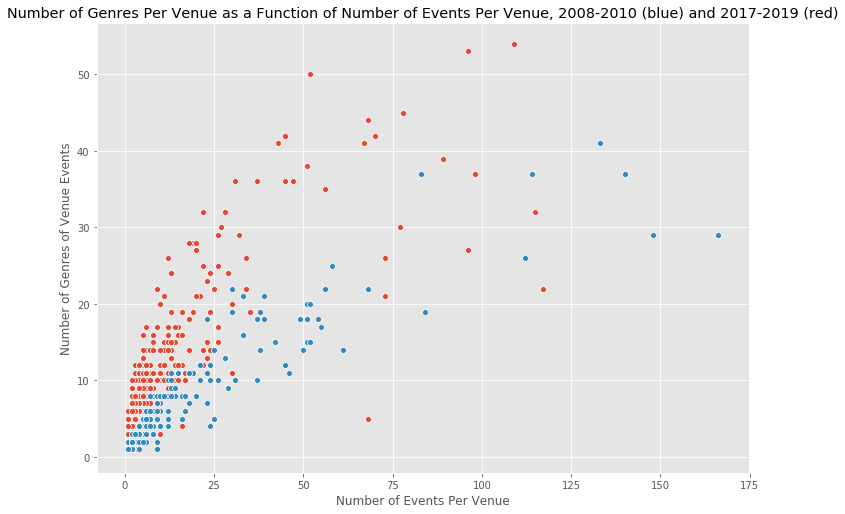

In [23]:
#scatterplots of correlation between number of events and number of genres per venue 

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27) 


sns.scatterplot(x = 'num_events', y = 'num_genres', data = venue_num_event_num_genre_recent, palette = 'Set3')  


sns.scatterplot(x = 'num_events', y = 'num_genres', data = venue_num_event_num_genre_old, palette = 'Set3')  

plt.xlabel('Number of Events Per Venue') 
plt.ylabel('Number of Genres of Venue Events')
plt.title("Number of Genres Per Venue as a Function of Number of Events Per Venue, 2008-2010 (blue) and 2017-2019 (red)")  

In [24]:
#Pearson correlation between number of events and number of genres per venue, 2017-2019 and 2008-2010 datasets 

event_genre_corr_recent = venue_num_event_num_genre_recent['num_events'].corr(venue_num_event_num_genre_recent['num_genres'], method = 'pearson') 
event_genre_corr_old = venue_num_event_num_genre_old['num_events'].corr(venue_num_event_num_genre_old['num_genres'], method = 'pearson') 
print(event_genre_corr_recent) 
print(event_genre_corr_old) 

0.8143772343790433
0.9123783091047396


For both the recent and historic data, number of events and number of genres per venue seem to have a strong positive correlation. 

### Aside: Genre and Title Word Clouds 

To further illustrate differences between typical genre categories of the recent and historic datasets, word clouds for each were generated: 

In [25]:
import nltk
from wordcloud import WordCloud 

In [26]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [27]:
from PIL import Image 

In [28]:
mask1 = np.array(Image.open('jp_flag.jpg')) 

In [29]:
"""word cloud for 2017-2019 dataset:"""

wc1 = WordCloud(background_color="red", mask = mask1, max_words=2000)
# generate word cloud
wc1.generate(' '.join(tokyo_first_100_category['categories_y'])) 

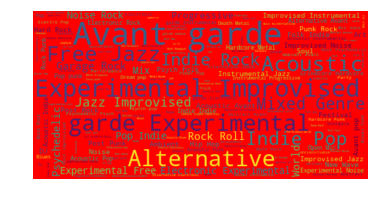

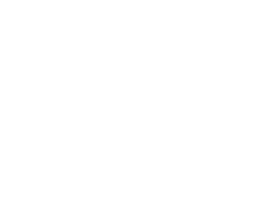

In [30]:
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(4, 3))
plt.axis("off")
plt.show()   

In [31]:
""" From 2008-2010: """

wc2 = WordCloud(background_color= "blue", mask = mask1, max_words=2000) 
wc2.generate(' '.join(tokyo_last_100_category['categories_y'])) 


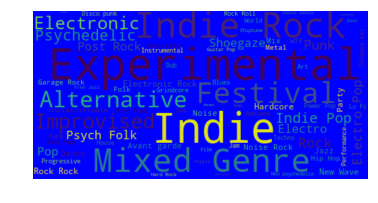

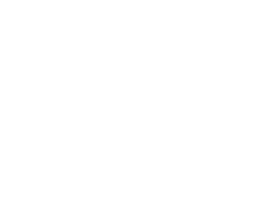

In [32]:
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(4, 3))
plt.axis("off")
plt.show()  

In [33]:
"""Word cloud for titles, drawn from recent dataset: """

mask2 = np.array(Image.open('mt_fuji_background.png'))

wc3 = WordCloud(background_color="white",  max_words=4000)
# generate word cloud
wc3.generate(' '.join(tokyo_first_100['title']))  

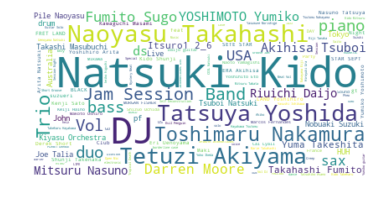

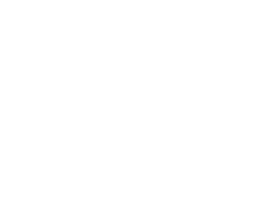

In [34]:
plt.imshow(wc3, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(4, 3))
plt.axis("off")
plt.show() 

In [35]:
"""...and 2008-2010 data: """

wc4 = WordCloud(background_color="white",  max_words=4000)
# generate word cloud
wc4.generate(' '.join(tokyo_last_100['title']))  

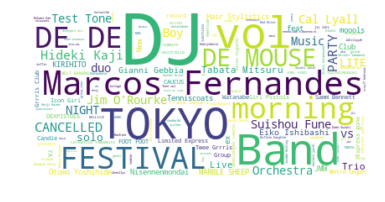

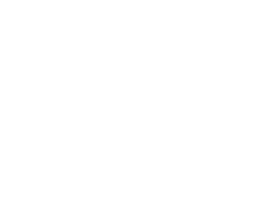

In [36]:
plt.imshow(wc4, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(4, 3))
plt.axis("off")
plt.show()  

### Aside: Maps 


Below are 2 interactive map visualizations, depicting events and venue distribution across the Tokyo area. In the first, each point represents a single venue (size and color relative to number of events); in the second, points represent geographic areas (neighborhoods), size and color relative to number of venues per area. In order to generate these maps, the dataframe containing longitude/latitude coordinates is merged with data aggregated on number of unique events per venue and number of unique venues per area, respectively. 

In [37]:
"""Dataframe 1: number of events/venue """ 

tokyo_for_map_venue = pd.DataFrame(tokyo_all_coords.groupby('venue').agg({'title': 'nunique'})).sort_index()
tokyo_for_map_venue = pd.DataFrame(tokyo_for_map_venue.to_records()) 
tokyo_for_map_venue.columns = ['venue','num_events']

tokyo_for_map_venue = pd.merge(tokyo_for_map_venue, tokyo_all_coords[['venue', 'area', 'Longitude', 'Latitude']], how = 'left', left_on = 'venue', right_on = 'venue')

#delete any duplicate venue listings     
tokyo_for_map_venue.drop_duplicates('venue', inplace = True) 

"""fill in missing latitude/longitude values, prioritizing: 
   1) areas with high concentration of venues (depth) and 2) geographic spread (breadth)""" 

def fill_missing_coords (df): 
    areas = ['Shibuya', 'Shinjuku', 'Roppongi', 'Koenji', 'Kichijoji', 'Shimokitazawa', 'Yokohama', 'Chiba', 'Shin-Kiba', 'Daikanyama', 'Asagaya', 'Ogikubo', 'Fuchu', 'Koiwa', 'Suidobashi', 'Ebisu', 'Omotesando', 'Aoyama', 'Tokyo', 'Kyodo', 'Nakano', 'Ikebukuro', 'Hachioji', 'Saitama', 'Ekoda', 'Azabu', 'Kunitachi', 'Tachikawa', 'Kokubunji', 'Shinagawa']
    vals = [(139.7038, 35.6620), (139.7034, 35.6938), (139.7345, 35.6619), (139.6465, 35.7079), (139.5802, 35.7041), (139.6670, 35.6616), (139.6380,35.4437), (140.1833, 35.3354), (139.8266, 35.6390), (139.7042, 35.6505), (139.6376, 35.7100), (139.6002, 35.7037), (139.4777, 35.6690), (139.8819, 35.7330), (139.7535, 35.7020), (139.7154, 35.6461), (139.6503, 35.6762), (139.7192, 35.6695), (139.7671, 35.6812), (139.6312, 35.6490), (139.6638, 35.7075), (139.7077, 35.7348), (139.3160, 35.6664),(139.6455, 35.8616), (139.6727, 35.7375), (139.7345, 35.6573), (139.4414, 35.6840), (139.4080, 35.7134), (139.4632, 35.7104), (139.7303, 35.6092)] 

    area_coord_dict = dict(zip(areas, vals)) 

    for key, v in area_coord_dict.items(): 
        df.loc[df['area'].str.contains(key),'Longitude'] = v[0]
        df.loc[df['area'].str.contains(key), 'Latitude'] = v[1]     
        

fill_missing_coords(tokyo_for_map_venue)


In [38]:
"""Dataframe 2: number of venues/area"""


tokyo_for_map_area = pd.DataFrame(tokyo_all_coords.groupby('area').agg({'venue': 'nunique'})).sort_index()

tokyo_for_map_area = pd.DataFrame(tokyo_for_map_area.to_records()) 

tokyo_for_map_area.columns = ['area','num_venues']



tokyo_for_map_area = pd.merge(tokyo_for_map_area, tokyo_all_coords[['area', 'Longitude', 'Latitude']], how = 'left', left_on = 'area', right_on = 'area')

#delete any duplicate area listings     
tokyo_for_map_area.drop_duplicates('area', inplace = True) 

fill_missing_coords(tokyo_for_map_area)  

In [39]:
init_notebook_mode(connected=True) 

In [59]:
 """map 1: venue distribution map 
    point size/color = number of events/venue """

   #mapbox_access_token = mapbox_access_token (to retrieve a token, create Mapbox account)


venue_lat = tokyo_for_map_venue.Latitude
venue_lon = tokyo_for_map_venue.Longitude
venue_locations_name = tokyo_for_map_venue.venue
num_events =tokyo_for_map_venue.num_events 
map_text = list(map(lambda x, y: ": ".join([x, str(y)]), venue_locations_name, num_events))

data = [
        go.Scattermapbox(
        lat=venue_lat,
        lon=venue_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size = num_events,
            sizeref = 35, 
            sizemin = 5, 
            color = num_events,
            colorbar = dict(title = 'Number of Events per Venue'), 
            colorscale = 'Jet',
            opacity= 0.4
        ),
        
        text = map_text,   
        hoverinfo= 'text'
    )] 
    
    
        
layout = go.Layout(
    title='Tokyo Venue Locations (point colors and sizes relative to number of events per venue)',
    autosize=True,
    hovermode='closest',
    showlegend = False,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=35.6762,
            lon = 139.6503
        ),
        pitch=0,
        zoom= 11,
        style='light'
      )
    )

fig = dict(data=data, layout=layout)   
iplot(fig, show_link = True)   
 

In [62]:
"""map 2: number of venues per area 
   point size = number of events/venue"""

#mapbox_access_token = mapbox_access_token (to retrieve a token, create Mapbox account)


area_lat = tokyo_for_map_area.Latitude
area_lon = tokyo_for_map_area.Longitude
area_locations_name = tokyo_for_map_area.area 
num_venues = tokyo_for_map_area.num_venues
map_text = list(map(lambda x, y: ": ".join([x, str(y)]), area_locations_name, num_venues))

data = [
        go.Scattermapbox(
        lat=area_lat,
        lon=area_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size = num_venues,  
            sizeref = 0.7, 
            sizemin = 5, 
            color = num_venues, 
            colorbar = dict(title = 'Number of Venues'), 
            colorscale = 'Jet',
            opacity= 0.4
        ),
        
        text = map_text,
        hoverinfo= 'text',
        
    )]
        
layout = go.Layout(
    title='Number of Venues Per Area of Tokyo (point colors and sizes relative to number of venues per area)',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=35.6762,
            lon = 139.6503
        ),
        pitch=0,
        zoom= 11,
        style='light'
    ),
)

fig = dict(data=data, layout=layout)   
iplot(fig, show_link = True)  

## EDA Part 3: Time Series Analyses 

Text(0.5,1,'Total Number of Events by Month')

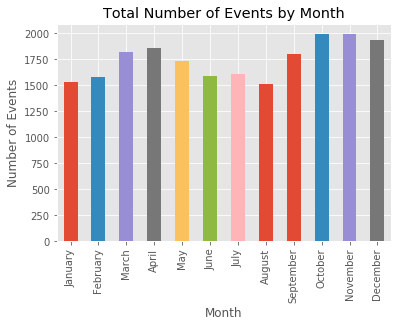

In [66]:
"""Total number of events by month, between 2008-2019: """

events_by_month = (tokyo_all.groupby(tokyo_all['date'].dt.strftime( '%m %B'))['title'].agg('count')).sort_index() 
events_by_month.index = [x.split()[1] for x in events_by_month.index]
events_by_month.plot.bar() 
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.title('Total Number of Events by Month')  

In [46]:
""" Number of events for top 5 genres by month between 2017-2019"""
tokyo_top_5_genres_num_events = pd.DataFrame({'num_events': tokyo_first_100_category.groupby(['categories_y', tokyo_first_100_category['date'].dt.strftime('%m %B')])['title'].agg('nunique')})
tokyo_top_5_genres_num_events.index = tokyo_top_5_genres_num_events.index.set_names(['category', 'month'])
tokyo_top_5_genres_num_events.reset_index(inplace = True)
tokyo_top_5_genres_num_events = tokyo_top_5_genres_num_events[tokyo_top_5_genres_num_events['category'].isin(['Improvised', 'Experimental', 'Avant garde', 'Acoustic', 'Alternative'])]
tokyo_top_5_genres_num_events.month = [x.split()[1] for x in tokyo_top_5_genres_num_events.month]


Text(31.459,0.5,'Number of Events')

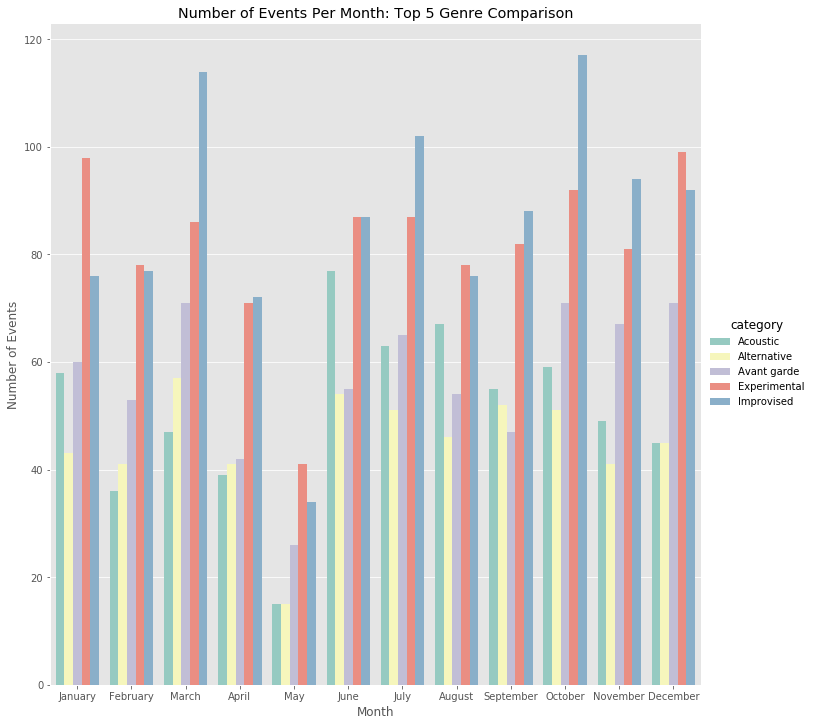

In [47]:
sns.catplot(x = 'month', y = 'num_events', hue = 'category', data =tokyo_top_5_genres_num_events, kind = 'bar', height = 10, palette="Set3")  

plt.title('Number of Events Per Month: Top 5 Genre Comparison') 
plt.xlabel('Month')
plt.ylabel('Number of Events')

In [48]:
"""Number of events per month by area (facet)"""

tokyo_top_5_areas_num_events = pd.DataFrame({'num_events': tokyo_first_100.groupby(['area', tokyo_first_100['date'].dt.strftime('%m %B')])['title'].agg('nunique')})
tokyo_top_5_areas_num_events.index = tokyo_top_5_areas_num_events.index.set_names(['area', 'month'])
tokyo_top_5_areas_num_events.reset_index(inplace = True)
tokyo_top_5_areas_num_events = tokyo_top_5_areas_num_events[tokyo_top_5_areas_num_events['area'].isin(['Shibuya', 'Koenji', 'Shimokitazawa', 'Shinjuku', 'Roppongi'])]
tokyo_top_5_areas_num_events.month = [x.split()[1] for x in tokyo_top_5_areas_num_events.month]

Text(31.1278,0.5,'Number of Events')

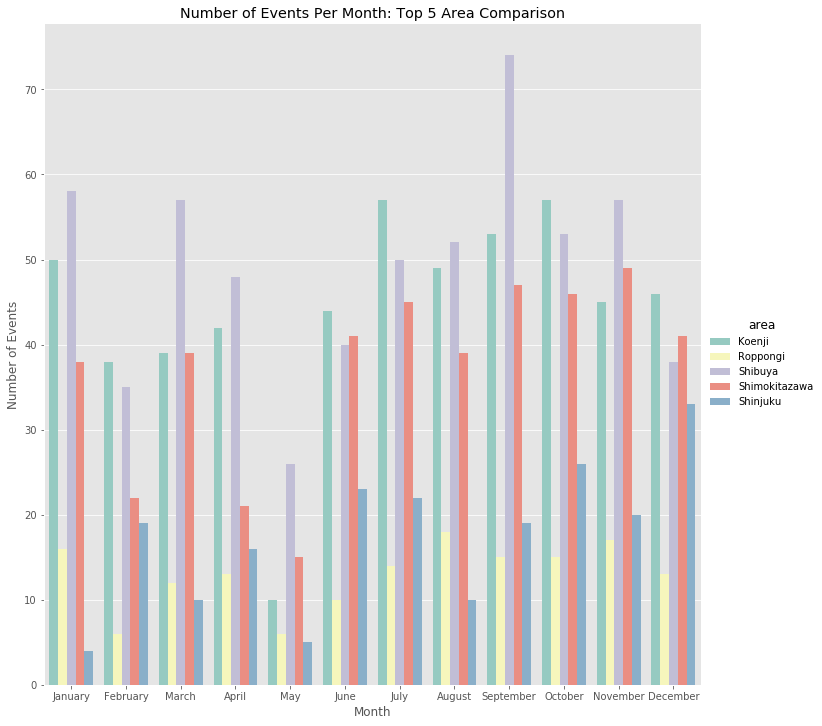

In [49]:
sns.catplot(x = 'month', y = 'num_events', hue = 'area', data =tokyo_top_5_areas_num_events, kind = 'bar', height = 10, palette="Set3")  

plt.title('Number of Events Per Month: Top 5 Area Comparison') 
plt.xlabel('Month')
plt.ylabel('Number of Events')

The above plots represent aggregates over the span of a decade (in the first case), or ca. 2.5 years (in the second two). The months of October and November appear to be more active than others. In the next plot, the range of numbers of events for each calendar month between the years 2008-2019 is represented: 

Text(0,0.5,'Number of Events')

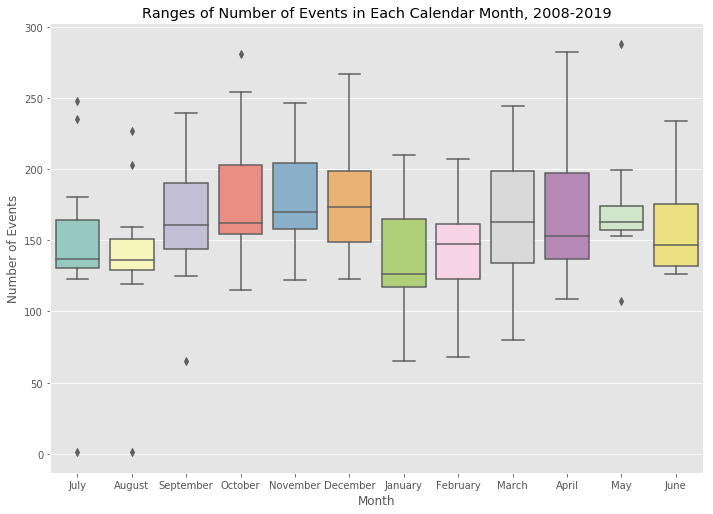

In [51]:
#boxplot of events by month to show variance 
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27) 
plt.title('Ranges of Number of Events in Each Calendar Month, 2008-2019')

event_num_by_year = pd.DataFrame({'num_events': tokyo_all.groupby([tokyo_all['date'].dt.year.rename('year'),tokyo_all['date'].dt.month])['title'].agg('count')})
event_num_by_year.index = event_num_by_year.index.set_names(['year', 'month'])
event_num_by_year.reset_index(inplace = True)
month_dict = {1: 'January', 2:'February', 3:'March', 4: 'April', 5: 'May', 6:'June', 7: 'July', 8: 'August', 9:'September', 10: 'October', 11: 'November', 12: 'December'} 

event_num_by_year.month = [month_dict[x] for x in event_num_by_year.month]




sns.boxplot(x = 'month', y = 'num_events', data = event_num_by_year, palette="Set3")
plt.xlabel('Month')
plt.ylabel('Number of Events') 

Festival histogram: number of festivals between 2008-2019. From the data, it appears that the peak of number of festival events posted to the Tokyo Gig Guide occurred in 2012-2013. 

Text(0.5,1,'Number of Festivals Between 2008-2019')

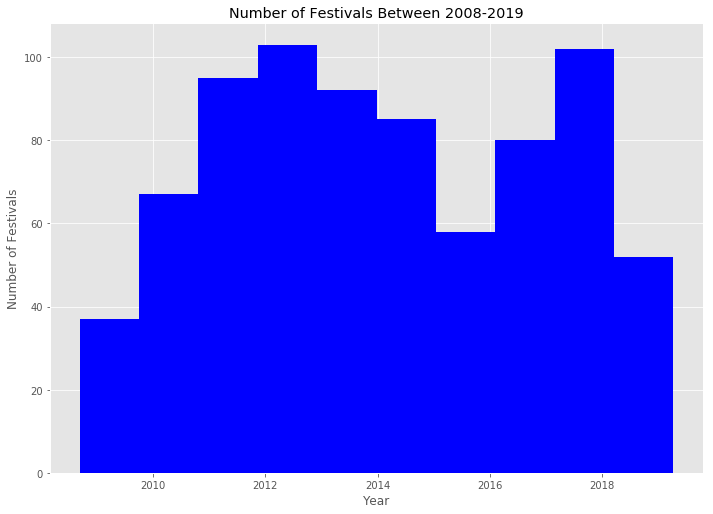

In [52]:

fig, ax = plt.subplots() 
fig.set_size_inches(11.7, 8.27) 
ax = plt.gca() 
ax.hist(festival_df['date'].values, color = 'blue') 
plt.xlabel('Year')
plt.ylabel('Number of Festivals')
plt.title('Number of Festivals Between 2008-2019') 

## EDA Pt. 4: Ticket Price-Related Analyses 

While event category (genre) formats are standarized on the Tokyo Gig Guide site, ticket price information is not. There are numerous cases of missing data, and values may include currency (¥/yen/円) or extended text entries. In addition, there are "advanced price" and "door price" categories. Before proceeding further, some standardization (i.e., extracting numerical information and converting to integers) is essential. 


In [68]:
""" argument: string or NaN in dataframe column
    returns: extracted price value as integer"""


def extract_price(string): 
    string = string.replace(',', '') #for price values containing commas (e.g., '14,000')
    string = string.replace('1 day', '')
    
    if string.strip() == '': string = '0'
    if string == 'N/A': return 'N/A'

    pattern = '|'.join(['free', 'Free', 'FREE!']) #for free events not denoted as "0"
    
    if pattern in string and len(string)<=6: #as there are rows which contain the word "free" in a sentence context
        string.replace(pattern, '0') 
    
    if string[0].isdigit() == False: 
        string = string[1:len(string)]
    i = 0
    price = ''
    
    while i < len(string):   
        if string[i].isdigit() == False: 
            if string[i-1].isdigit(): 
                break 
            else: 
                i += 1
                continue
        else: 
            price = price + string[i]  
            i+=1
            
        
    if price == '':  
        price = '0'
    

    return int(price)       


In [54]:
extract_price('donation + five yen')

0

In [55]:
extract_price('¥5000')

5000

In [56]:
extract_price('FREE!')

0

In [57]:
extract_price('N/A')

'N/A'

In [58]:
extract_price('')

0

In [69]:
""" arguments: dataframe
    returns: dataframe with tidied price columns and additional 'max price' column"""

def prepare_price_columns (df): 
        
    df = df.fillna('N/A')  #replace NaN with strings for purposes of extract_price function 
        
    df['door_price'] = df['door_price'].apply(extract_price) 
    df['advance_price'] = df['advance_price'].apply(extract_price) 

    df[['advance_price', 'door_price']] =  df[['advance_price', 'door_price']].replace('N/A', np.nan) 
        
    for column in ['advance_price', 'door_price']: 

        df[column] = df[column].fillna(df[column].mean()) #replace missing values with column means 
        
    df['max_price']  = df[['advance_price', 'door_price']].values.max(1) #max of advance and door price: use as reference
        
    return df    
        
        

In [70]:
tokyo_all = prepare_price_columns(tokyo_all)

In [71]:
tokyo_all.sample(10) 

index                                              title       date  \
6927    8615           Letting Up Despite Great Faults, SOARING 2012-11-13   
16818   3416  DOKUJIKI Improvised Solo Performance ONLY: Mar... 2017-09-21   
17791   2730                     Ryosuke Kiyasu snare drum solo 2018-01-24   
5456   10538                                                CSS 2012-01-14   
11895   3950  akafuji + Akiko Nakayama, Takako Minekawa & Du... 2015-09-21   
12276   4394                                         smallpools 2015-12-01   
5909    9307               Gianni Gebbia & Sonoda Ikumi (dance) 2012-04-14   
3707    1242  SHEENA & THE ROKKETS, Shonen Knife, kinocohote... 2011-01-23   
14770   1343         Keiji Haino meets New Rock Syndicate, DMBQ 2017-01-06   
3346     890  NINJA TUNE XX TOKYO with THE QEMISTS, DJ KENTA... 2010-11-05   

                                                category               venue  \
6927                                           Dream-pop              O-Nest   
16818  Acoustic,Avant garde,Dance,Experimental,Improv...             Violon    
17791  Acoustic,Avant garde,Free Jazz,Improvised,Inst...       Flying Teapot   
5456                                     Electronic Rock        Studio Coast   
11895                                       Experimental                 N/A   
12276                                       Indie-Pop,    DUO Music Exchange   
5909                                          Improvised             Muriwui   
3707                                         Garage Rock              Garden   
14770                                   Psychedelic,Rock            UFO Club   
3346                                               Dance              O-East   

                                               venue_url  \
6927                       http://www.shibuya-o.com/nest   
16818                   http://meikyoku-kissa-violon.com   
17791  http://flyingteapot1997.wixsite.com/ekoda-flyi...   
5456                         http://www.studio-coast.com   
11895                                                N/A   
12276                    http://www.duomusicexchange.com   
5909      http://www.ne.jp/asahi/cafe/muriwui/index.html   
3707                               http://www.gar-den.in   
14770                              http://www.ufoclub.jp   
3346                            http://www.shibuya-o.com   

                                                 address  \
6927   ON AIR WEST bldg. 6F, 2-3 Maruyama-cho, Shibuy...   
16818              Suginami-ku Asagaya-Kita 2-9-5, Tokyo   
17791        Enomoto Bldg B1F, 27-7 Sakae-cho, Nerima-ku   
5456                           2-2-10 Shin-Kiba, Koto-ku   
11895                                                N/A   
12276                       2-14-8 Dogenzaka, Shibuya-ku   
5909                       4-1-22-3F Soshigaya, Setagaya   
3707              Mosia B1F, Kitazawa 2-4-5, Setagaya-ku   
14770  Harmony Hills B1F 1-11-6 Koenji-Minami,Suginam...   
3346                     2F 2-14-9 Dogenzaka, Shibuya-ku   

                                          access_url             area  \
6927                                             N/A          Shibuya   
16818                                            N/A          Asagaya   
17791                                            N/A            Ekoda   
5456                                             N/A        Shin-Kiba   
11895                                            N/A              N/A   
12276                                            N/A          Shibuya   
5909   http://www.ne.jp/asahi/cafe/muriwui/info.html  Soshigaya-Ōkura   
3707                                             N/A    Shimokitazawa   
14770                  http://www.ufoclub.jp/access/   Higashi-Koenji   
3346                                             N/A          Shibuya   

              closest_station  advance_price   door_price  \
6927                  Shibuya    3500.000000  4000.000000   
16818    J.R. Asaga

Average ticket price: 

In [75]:
tokyo_all['max_price'].mean() 

3211.2853984099424

In [76]:
tokyo_all['max_price'].median()

2990.976117886179

Ticket price ranges for areas with greatest number of venues: 



Text(0.5,1,'Highest Ticket Price by Area')

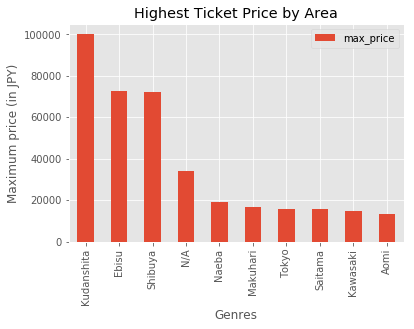

In [74]:
tokyo_all_category.groupby('area').agg({'max_price': 'max'}).sort_values(by = 'max_price', ascending = False).head(10).plot.bar()
plt.xlabel('Genres')
plt.ylabel('Maximum price (in JPY)') 
plt.title('Highest Ticket Price by Area') 


Text(0,0.5,'Price (in JPY)')

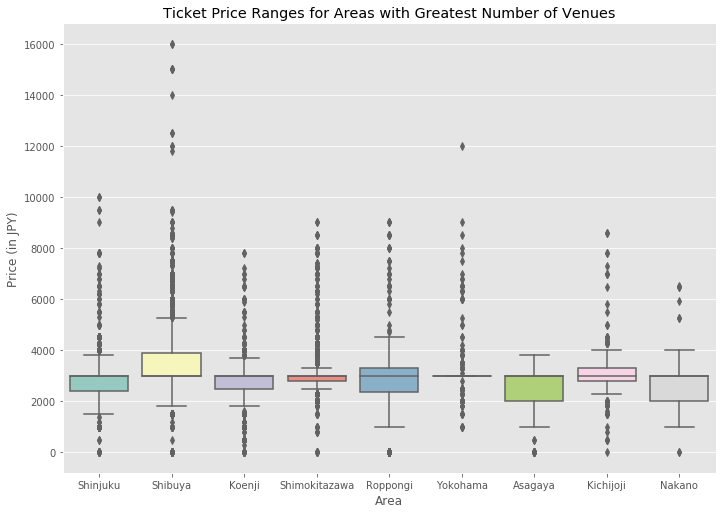

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27) 
plt.title('Ticket Price Ranges for Areas with Greatest Number of Venues')


areas = ['Shibuya', 'Shimokitazawa', 'Koenji', 'Shinjuku', 'Nakano', 'Kichijoji',  'Roppongi', 'Asagaya', 'Yokohama']

tokyo_all_price_filtered = tokyo_all[tokyo_all['max_price']< 20000] #filter out outliers 

sns.boxplot(x = 'area', y = 'max_price', data = tokyo_all_price_filtered [tokyo_all_price_filtered ['area'].isin(areas)], palette="Set3")
plt.xlabel('Area')
plt.ylabel('Price (in JPY)')


Most expensive shows (venue, title, category, date, and price): 

In [64]:
most_expensive_shows = pd.DataFrame(tokyo_all.groupby(['venue', 'title', 'category', 'area']).agg({'max_price': 'max'}).sort_values(by = 'max_price', ascending = False).head(10))
print(most_expensive_shows)
most_expensive_shows.to_csv('data/most_expensive_shows.csv') 

                                                                                                    max_price
venue            title                                              category            area                 
Budokan          Paul McCartney                                     Rock,Pop            Kudanshita   100000.0
Liquidroom       PAELLAS                                            Indie,Pop           Ebisu         72733.0
O-East           SYNCHRONICITY ’16 - After Hours                    Festival            Shibuya       72102.0
O-Nest           DEAD PAN SPEAKERS, ELMO, 蟬, とんちピクルス, U span D, ... Mixed Genre         Shibuya       70435.0
N/A              ARCADIA JAPAN                                      Electronic,Festival N/A           34000.0
                                                                    Festival            N/A           34000.0
                 MATE ROCK: Jimmy Barnes and Mahalia Barnes, The... Rock                N/A           25000.0
          

As is to be expected, international celebrities such as Paul McCartney and Björk, and major rock and electronica festivals yield the highest ticket prices.  

Range of ticket prices by genre: 

In [73]:
tokyo_all_category = prepare_price_columns(tokyo_all_category) 

Text(0.5,1,'Highest Ticket Price by Genre')

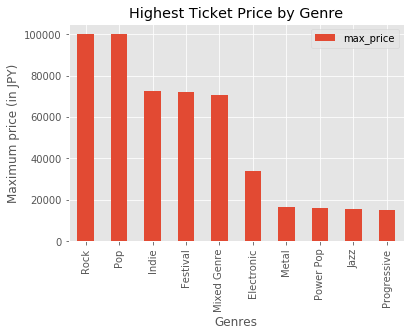

In [66]:
tokyo_all_category.groupby('categories_y').agg({'max_price': 'max'}).sort_values(by = 'max_price', ascending = False).head(10).plot.bar()
plt.xlabel('Genres')
plt.ylabel('Maximum price (in JPY)') 
plt.title('Highest Ticket Price by Genre') 

Text(0,0.5,'Price (in JPY)')

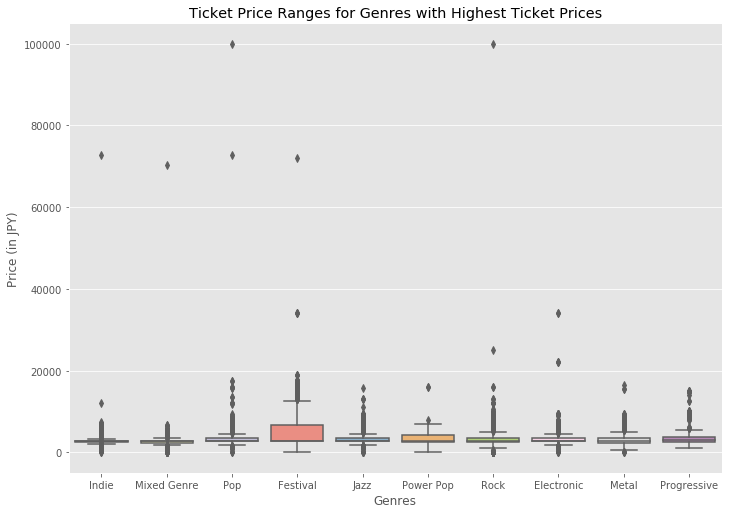

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27) 
plt.title('Ticket Price Ranges for Genres with Highest Ticket Prices') 

genres = ['Rock', 'Pop', 'Indie', 'Festival', 'Mixed Genre', 'Electronic', 'Metal', 'Power Pop', 'Jazz', 'Progressive']

sns.boxplot(x = 'categories_y', y = 'max_price', data = tokyo_all_category[tokyo_all_category['categories_y'].isin(genres)], palette="Set3")
plt.xlabel('Genres')
plt.ylabel('Price (in JPY)') 

It appears that the most expensive shows are outliers for all genres. To gain a more accurate sense of typical price ranges, let's filter out shows with ticket prices above ¥20,000: 

Text(0,0.5,'Price (in JPY)')

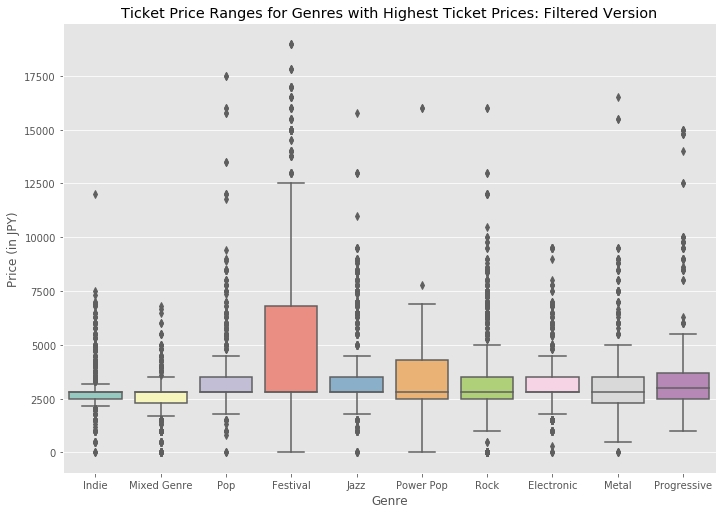

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27) 
plt.title('Ticket Price Ranges for Genres with Highest Ticket Prices: Filtered Version') 

tokyo_all_category_filtered = tokyo_all_category[tokyo_all_category['max_price'] < 20000] 

sns.boxplot(x = 'categories_y', y = 'max_price', data = tokyo_all_category_filtered[tokyo_all_category_filtered['categories_y'].isin(genres)], palette="Set3")
plt.xlabel('Genre')
plt.ylabel('Price (in JPY)') 

These results are likely due to the number of missing values in the price category...but "Festival" (which is, strictly speaking, not a unified genre) has the greatest spread and IQR, followed by "Power Pop". Here are the stats for Power Pop: 

In [69]:
tokyo_all_category_filtered[tokyo_all_category_filtered['categories_y'] == 'Power Pop']['max_price'].describe()   

count       91.000000
mean      3630.127251
std       2483.712802
min          0.000000
25%       2500.000000
50%       2785.068541
75%       4300.000000
max      16000.000000
Name: max_price, dtype: float64

## Conclusion


From the above analyses, it is evident that the rankings of genre tags have shifted over the past decade. The most significant shift occurred in 2012-2013, at which time the genre "Indie" declined in appearances, and "Improvised" increased. By contrast, there have been few changes with respect to most active areas (neighborhoods) in Tokyo...but the respective distributions of events per area and the most active venues in those areas are significantly different. 

There is a strong positive correlation between number of events and number of genres represented by a given venue. 

October and November have been the most active months. However, based upon each month's IQR with respect to number of events, there are sizable differences from one year to the next. IQR's for May and August are the narrowest. 

In 2012, the peak number of festivals was recorded. 

The most expensive posted event was a Paul McCartney concert in Kudanshita (¥100,000 = ca. 1000 USD). The average ticket price for the entire dataset was ¥3,211 (ca. 32 USD). Ticket prices for most events fell under ¥20,000, and there seemed to be no strong correlation between area or genre and price once outliers were filtered out. Caveat: given the quantity of missing ticket price data, it is impossible to draw solid conclusions in this regard. 

In future, it would be of interest to integrate the Tokyo Gig Guide datasets with other event listing data, to perform more rigorous NLP on event titles, and to extend the date range. The analyses encapulsated by this project could be utilised to construct a classification model to predict genre based upon venue, title, date, and (possibly) ticket price variables. 







